# Sistemas de controle com python
Este é um python notebook, criado para realizar projetos de controladores em avanço, atraso, avanço e atraso por lugar das raises e por resposta em frequencia. Além da implementação de compensadores PI e PID.

| Role                 | Responsibility         | Full name                | e-mail       |
| -----              | ----------------       | -----------              | ---------    |
| Dev             | Author                 | `João Gustavo Atkinson Amorim`          | `joaogustavoamorim@gmail.com` |
| Teacher     | Co-author            | `Rodrigo Iván Goytia Mejia`            | `rodrigo-mejia@uergs.edu.br` |

  
Instalando a biblioteca control com pip. Esta [lib control](https://python-control.readthedocs.io/en/0.8.2/index.html) é a responsavel pelas funções de sistemas de controle utilizadas durante o código.

In [0]:
!pip install control

Importando o modulo de compatibilidade com o MATLAB.
Este modulo possui as funções com os mesmos nomes encontrados no MATLAB.

In [0]:
from control.matlab import *

# Importações de bibliotecas

In [0]:
from control.matlab import *              # Biblioteca de controle
import numpy as np                        # Biblioteca com funções matematicas
import matplotlib as mpl                  
import matplotlib.pyplot as plt           # Para realizar plotagens de funções
from sympy import *                       # Para adicionar simbolos e resolver a equações

# Especificações de entradas

In [0]:
Nit        = 200                    # Número de iterações
t          = range(Nit)             # Tempo
ramp       = t                      # Rampa
step       = np.ones(Nit)           # Degrau
dist_p     = np.concatenate((np.zeros(round(Nit/2)),np.ones(round(Nit/2))), axis=0)
med        = 0;
stdn       = 0.05;
dist_n     = med + stdn * np.random.rand(Nit);

# Controlador em avanço por lugar das raises
R━━━━━━ **+** → ▇ ━━━━━━→ C(s)━━━━━━→ G(s) ━━━━━━┳━━━━━━→Y\
....................**-**↑..............................................................┃\
.....................┃...............................................................┃\
.....................┃━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┃

Onde:
* o bloco C(s) é o compensador a ser desenvolvido. C(s) = Kc * (s+z)/(s+p)
* o bloco G(s) é a planta do sistema.
* R é o sinal de entrada do sistema (degrau, rampa, etc).
* Y é a resposta do sistema controlado prando a uma entrada R.

erro = e =  R - Y = (R * G(s) * C(s)) / (1+G(s) * C(s)) \
saida do controlador = u = e * C(s)\
Y = u * G = e * C(s) * G(s)\
Y/R = M(s) = (G(s) * C(s)) / (1+G(s) * C(s))

## Especificações de projeto
G(s) = 0.1 / ((s+1)*(s+0.5))  \
  Especificações de MF:\
*    ep(inf) <= 0.1  %erro no infinito
*    Mp%    <= 10   %overshoot
*    ts         <= 2     % segundos
    
-----------------


In [0]:
# Parametros da planta {G(s)}
Kp_MA           = 0.1
Numerador       = Kp_MA
Denominador     = np.convolve([1,1], [1,0.5])

# Especificações a serem alcançadas
ts_esp          = 2                                       # tempo de pico em segundos esperado
Mp_esp          = 10                                      # overshoot esperado em porcentagem
Mp_folga        = 5                                       # folga dada ao Mp, pq da aproximação de compensador para 2ª ordem
e_esp           = 0.1                                     # Erro esperado no estado estacionario

## 1. Verificando comportamento em MA (Malha Aberta)

Gma=
       0.1
-----------------
s^2 + 1.5 s + 0.5

e(∞) = 0.8
Polos de G(s) -> [-1.  -0.5]
Zeros de G(s) -> []
stepinfo: 
	RiseTime: 5.143143143143144
	SettlingTime: 9.03903903903904
	SettlingMin: 0.17974958065913382
	SettlingMax: 0.19963541351952674
	Overshoot: 0.0
	Undershoot: 0.0
	Peak: 0.19963541351952674
	PeakTime: 14.0
	SteadyStateValue: 0.19963541351952674


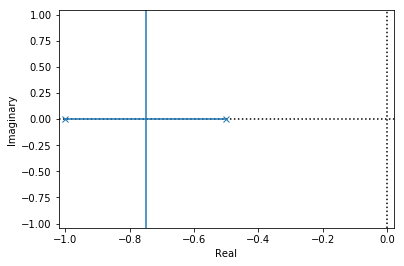

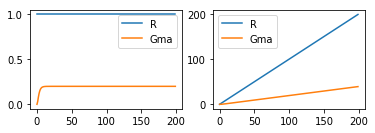

In [0]:
G_MA = tf(Numerador, Denominador)                          # FT em MA, C = 1
print(f"Gma={G_MA}")

e_MA = 1 - dcgain(G_MA)                                   # Erro da planta em MA
print(f"e(∞) = {e_MA}")

# Salva e exibe os polos e zeros da planta
polos_MA = pole(G_MA)
zeros_MA = zero(G_MA)
print(f"Polos de G(s) -> {polos_MA}")
print(f"Zeros de G(s) -> {zeros_MA}")

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MA = stepinfo(G_MA)
print(f"stepinfo: ")
for info in infoG_MA:
  print(f"\t{info}: {infoG_MA[info]}")

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MA, step, t)
y_ramp = lsim(G_MA, ramp, t)
rlocusG_MA = rlocus(G_MA)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gma"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gma"])
plt.show()

## 2. Determinando as especificações do compensador

In [0]:
# Determinando ganho do compensador, Kc
Kp_s    = symbols('Kp_s')
eq_Kp   = [(1/(1+Kp_s)) - e_esp]
Kp      = solve(eq_Kp, Kp_s)
Kp      = Kp[Kp_s]

Kc_s    = symbols('Kc_s')
eq_Kc   = [((Kc_s*dcgain(G_MA)) - Kp)]
Kc      = solve(eq_Kc, Kc_s)
Kc      = round(Kc[Kc_s], 4)

print(f"Kc = {Kc}")

# Determinando o coeficiente de amortecimento, psi = ξ
psi     = np.arange(0, 1, 0.01)
MpVetor = 100*np.exp(((-1*psi*np.pi)/np.sqrt(1-psi**2)))
MpLoc   = np.where(MpVetor>=(Mp_esp-Mp_folga))[-1][-1] + 1
psi     = round(psi[MpLoc], 4)

print(f"ξ  = {psi}")

# Determinando a frequencia natural, Wn
Wn_s    = symbols('Wn_s')
eq_Wn   = [4/(psi*Wn_s)-ts_esp]
Wn      = solve(eq_Wn, Wn_s)
Wn      = round(Wn[Wn_s], 4)

print(f"Wn = {Wn}\t rad/s")

# Parametros de uma função de 2ª ordem
sigma   = psi * Wn
Wd      = Wn * np.sqrt(1-psi**2)

print(f"σ  = {sigma}")
print(f"Wd = {Wd}")

Kc = 45.0
ξ  = 0.7
Wn = 2.8571	 rad/s
σ  = 1.9999699999999998
Wd = 2.0403775163189777


## 3. Determinando o polo e o zero do compensador

In [0]:
# Determinação do zero
  # a) polos dominantes do sistema
s = []
s.append(complex(-sigma, Wd))
s.append(complex(-sigma, -Wd))
  
  # b) determinando o polo
zero_c     = -sigma

print(f"Zero controlador -> {zero_c}")

# Determinação do polo
  # a) determinando theta, angulo entre o zero e o polo dominante
thetaZero   = np.arctan2(s[0].imag, s[0].real - zero_c.real)
thetaZeroD  = np.degrees(thetaZero)
print(f"Angulo entre o zero do controlador e o polo dominante = ϴ =")
print(f"\t= {round(thetaZeroD,4)}º = {round(thetaZero,4)} rad")

  # b) determinando phi pela condição de fase
phiPolo = []
textSum = "("

for k in range(len(polos_MA)):
  phiPolo.append(np.arctan2(s[0].imag, s[0].real - polos_MA[k]))
  print(f"φ{k} = {round(phiPolo[-1], 4)} rad")
  textSum += f"+ {round(np.degrees(phiPolo[-1]), 3)} "
textSum += ")"

phiPoloD    = np.degrees(phiPolo)
phiPolo_C   = (180 - np.sum(phiPoloD) + thetaZeroD)

print(f"Angulo entre o polo do controlador e o polo dominante = φ{len(polos_MA)} =")
print(f"\t= 180 - {textSum} + {round(thetaZeroD,3)} =")
print(f"\t= {round(phiPolo_C, 4)}º = {round(np.radians(phiPolo_C),4)} rad")

  # c) determinando localização do polo
d_s         = symbols('d_s')
eq_d        = [s[0].imag/d_s - np.tan(np.radians(phiPolo_C))]
d           = solve(eq_d, d_s)
polo_c      = -1*(d[d_s] + abs(sigma))
print(f"Polo controlador -> {polo_c}")

Zero controlador -> -1.9999699999999998
Angulo entre o zero do controlador e o polo dominante = ϴ =
	= 90.0º = 1.5708 rad
φ0 = 2.0265 rad
φ1 = 2.2047 rad
Angulo entre o polo do controlador e o polo dominante = φ2 =
	= 180 - (+ 116.109 + 126.321 ) + 90.0 =
	= 27.5697º = 0.4812 rad
Polo controlador -> -5.90787816329788


## 4. Determinar o ganho do controlador, Kc, usando a condição de módulo

In [0]:
h = []
for k in range(len(polos_MA)): 
  h.append(np.sqrt((Wd-abs(polos_MA[k].imag))**2 + (abs(sigma) - abs(polos_MA[k].real))**2))
h.append(np.sqrt(float(((Wd-0)**2 + (abs(sigma) - abs(polo_c))**2))))

c = sqrt((Wd-0)**2 + (abs(sigma) - abs(zero_c))**2)

Kc = np.prod(h) / (c*Kp_MA)

print(f"Kc  = {Kc}")

Kc  = 124.327513419549


## 5. Monta controlador com os parametros determinados

In [0]:
numC    = np.array([1, -zero_c], dtype=float)
denC    = np.array([1, -polo_c], dtype=float)
C       = tf(float(Kc)*numC, denC)           # Controlador m avanço
print(f"Control of advancement = Kc * (s+z)/(s+p) = ")
print(f"\t= {Kc} *  (s+z)/(s+p) = \t{C}")

Control of advancement = Kc * (s+z)/(s+p) = 
	= 124.327513419549 *  (s+z)/(s+p) = 	
124.3 s + 248.7
---------------
   s + 5.908



## 6. Verifica o comportamento do sistema com o compensador

Malha Aberta
C(s) * G(s) = 
         12.43 s + 24.87
---------------------------------
s^3 + 7.408 s^2 + 9.362 s + 2.954

*********************************************
Malha Fechada
Gmf = 
         12.43 s + 24.87
---------------------------------
s^3 + 7.408 s^2 + 21.79 s + 27.82

*********************************************
e(∞) = 0.10618396700079724
*********************************************
stepinfo: 
	RiseTime: 0.5255334085266528
	SettlingTime: 2.0881194098792335
	SettlingMin: 0.8033480733388052
	SettlingMax: 1.0111964202486405
	Overshoot: 13.288674825328973
	Undershoot: 0.0
	Peak: 1.0111964202486405
	PeakTime: 1.1912090593270797
	SteadyStateValue: 0.8925838543064661


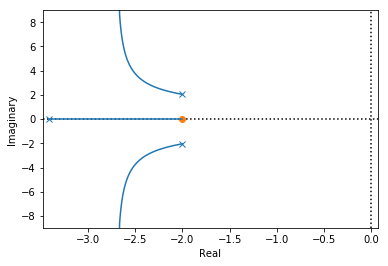

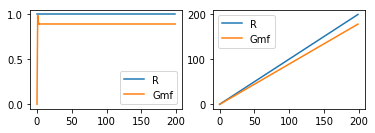

In [0]:
print("Malha Aberta")
CG_MA       = C * G_MA
print(f"C(s) * G(s) = {CG_MA}")

print("*********************************************")
print("Malha Fechada")
G_MF        = feedback(CG_MA, 1)
print(f"Gmf = {G_MF}")

print("*********************************************")
e_MF         = 1 - dcgain(G_MF)     #erro apos ser adicionado o controlador ao
print(f"e(∞) = {e_MF}")

print("*********************************************")

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MF     = stepinfo(G_MF)
print(f"stepinfo: ")
for info in infoG_MF:
  print(f"\t{info}: {infoG_MF[info]}")

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MF, step, t)
y_ramp = lsim(G_MF, ramp, t)
rlocusG_MF = rlocus(G_MF)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gmf"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gmf"])
plt.show()

# Controlador em atraso por lugar das raises
R━━━━━━ **+** → ▇ ━━━━━━→ C(s)━━━━━━→ G(s) ━━━━━━┳━━━━━━→Y\
....................**-**↑..............................................................┃\
.....................┃...............................................................┃\
.....................┃━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┃

Onde:
* o bloco C(s) é o compensador a ser desenvolvido. C(s) = Kc * (s+z)/(s+p)
* o bloco G(s) é a planta do sistema.
* R é o sinal de entrada do sistema (degrau, rampa, etc).
* Y é a resposta do sistema controlado prando a uma entrada R.

erro = e =  R - Y = (R * G(s) * C(s)) / (1+G(s) * C(s)) \
saida do controlador = u = e * C(s)\
Y = u * G = e * C(s) * G(s)\
Y/R = M(s) = (G(s) * C(s)) / (1+G(s) * C(s))

## Especificações de projeto
G(s) = 30  / ((s+5)*(s+3)*(s+2.5))  \
  Especificações de MF:\
*    ev(inf) <= 0.1  %erro no infinito
*    Mp%    <= 10   %overshoot
*    ts         <= 2     % segundos
    
-----------------


In [0]:
# Parametros da planta {G(s)}
Kp_MA           = 30
Numerador       = Kp_MA
Denominador     = np.convolve(np.convolve([1,5], [1,3]), [1,2.5])

# Especificações a serem alcançadas
ts_esp          = 2                                       # tempo de pico em segundos esperado
Mp_esp          = 10                                      # overshoot esperado em porcentagem
Mp_folga        = 5                                       # folga dada ao Mp, pq da aproximação de compensador para 2ª ordem
e_esp           = 0.1                                     # Erro esperado no estado estacionario

## 1. Verificando comportamento em MA (Malha Aberta)

Gma=
             30
----------------------------
s^3 + 10.5 s^2 + 35 s + 37.5

e(∞) = 0.19999999999999996
Polos de G(s) -> [-5.  -3.  -2.5]
Zeros de G(s) -> []
stepinfo: 
	RiseTime: 1.3117117117117212
	SettlingTime: 2.261861861861878
	SettlingMin: 0.7145056361723227
	SettlingMax: 0.7934936085379382
	Overshoot: 0.0
	Undershoot: 0.0
	Peak: 0.7934936085379382
	PeakTime: 2.8000000000000203
	SteadyStateValue: 0.7934936085379382


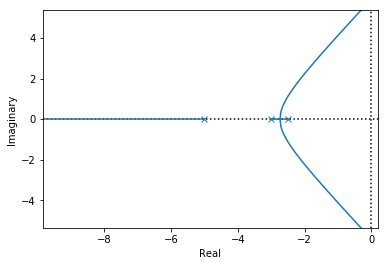

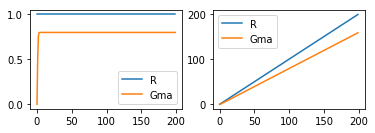

In [0]:
G_MA = tf(Numerador, Denominador)                          # FT em MA, C = 1
print(f"Gma={G_MA}")

e_MA = 1 - dcgain(G_MA)                                   # Erro da planta em MA
print(f"e(∞) = {e_MA}")

# Salva e exibe os polos e zeros da planta
polos_MA = pole(G_MA)
zeros_MA = zero(G_MA)
print(f"Polos de G(s) -> {polos_MA}")
print(f"Zeros de G(s) -> {zeros_MA}")

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MA = stepinfo(G_MA)
print(f"stepinfo: ")
for info in infoG_MA:
  print(f"\t{info}: {infoG_MA[info]}")

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MA, step, t)
y_ramp = lsim(G_MA, ramp, t)
rlocusG_MA = rlocus(G_MA)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gma"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gma"])
plt.show()

## 2. Determinando as especificações do compensador

In [0]:
# Determinando ganho do compensador, Kc
Kp_s    = symbols('Kp_s')
eq_Kp   = [(1/(1+Kp_s)) - e_esp]
Kp      = solve(eq_Kp, Kp_s)
Kp      = Kp[Kp_s]

Kc_s    = symbols('Kc_s')
eq_Kc   = [((Kc_s*dcgain(G_MA)) - Kp)]
Kc      = solve(eq_Kc, Kc_s)
Kc      = round(Kc[Kc_s], 4)

print(f"Kc = {Kc}")

# Determinando o coeficiente de amortecimento, psi = ξ
psi     = np.arange(0, 1, 0.01)
MpVetor = 100*np.exp(((-1*psi*np.pi)/np.sqrt(1-psi**2)))
MpLoc   = np.where(MpVetor>=(Mp_esp-Mp_folga))[-1][-1] + 1
psi     = round(psi[MpLoc], 4)

print(f"ξ  = {psi}")

# Determinando a frequencia natural, Wn
Wn_s    = symbols('Wn_s')
eq_Wn   = [4/(psi*Wn_s)-ts_esp]
Wn      = solve(eq_Wn, Wn_s)
Wn      = round(Wn[Wn_s], 4)

print(f"Wn = {Wn}\t rad/s")

# Parametros de uma função de 2ª ordem
sigma   = psi * Wn
Wd      = Wn * np.sqrt(1-psi**2)

print(f"σ  = {sigma}")
print(f"Wd = {Wd}")

Kc = 11.25
ξ  = 0.7
Wn = 2.8571	 rad/s
σ  = 1.9999699999999998
Wd = 2.0403775163189777


## 3. Determinando o polo e o zero do compensador

In [0]:
# Determinação do zero
#   % A) determinando o zero e o polo do controlador
#     % polo =  tem que ser um valor pequeno
#     % zero = polo + delta
#     % polo e o zero tem que estar proximos de zero para amplificar 
#     % Kc deve ser aproximadamente 1, mas nao foi calculado ainda, isto deve
#     % ocorrer para que nao ocorra erro no regime transitorio
    
# % Primeira tentativa / chute
polo_c = 0.01;  #% polo do controlador
#     %Kp = lim {Kc *G(s)*(s+Z_c)/(s+P_c)} quando s tende a 0
zero_c = float(polo_c*(Kp / dcgain(G_MA)));

# % Segunda tentativa / chute
polo_c = 0.165134;  #% polo do controlador
#     %Kp = lim {Kc *G(s)*(s+Z_c)/(s+P_c)} quando s tende a 0
zero_c = float(polo_c*(Kp / dcgain(G_MA)));

print(f"Zero controlador -> {zero_c}")
print(f"Polo controlador -> {polo_c}")

Zero controlador -> 1.8577575
Polo controlador -> 0.165134


## 4. Determinar o ganho do controlador, Kc, usando a condição de módulo

In [0]:
h = []
for k in range(len(polos_MA)): 
  h.append(np.sqrt((Wd-abs(polos_MA[k].imag))**2 + (abs(sigma) - abs(polos_MA[k].real))**2))
h.append(np.sqrt(float(((Wd-0)**2 + (abs(sigma) - abs(polo_c))**2))))

c = sqrt((Wd-0)**2 + (abs(sigma) - abs(zero_c))**2)

Kc = np.prod(h) / (c*Kp_MA)

print(f"Kc  = {Kc}")

Kc  = 0.774504797171011


## 5. Monta controlador com os parametros determinados

In [0]:
numC    = np.array([1, zero_c], dtype=float)
denC    = np.array([1, polo_c], dtype=float)
C       = tf(float(Kc)*numC, denC)           # Controlador em atraso
print(f"Control of lag = Kc * (s+z)/(s+p) = ")
print(f"\t= {Kc} *  (s+z)/(s+p) = \t{C}")

Control of lag = Kc * (s+z)/(s+p) = 
	= 0.774504797171011 *  (s+z)/(s+p) = 	
0.7745 s + 1.439
----------------
   s + 0.1651



## 6. Verifica o comportamento do sistema com o compensador

Malha Aberta
C(s) * G(s) = 
               23.24 s + 43.17
---------------------------------------------
s^4 + 10.67 s^3 + 36.73 s^2 + 43.28 s + 6.193

*********************************************
Malha Fechada
Gmf = 
               23.24 s + 43.17
---------------------------------------------
s^4 + 10.67 s^3 + 36.73 s^2 + 66.51 s + 49.36

*********************************************
e(∞) = 0.1254619638965605
*********************************************
stepinfo: 
	RiseTime: 1.0137099394042077
	SettlingTime: 2.8220869669845783
	SettlingMin: 0.7871707281713786
	SettlingMax: 0.9177569427303636
	Overshoot: 4.973605665937364
	Undershoot: 0.0
	Peak: 0.9177569427303636
	PeakTime: 2.1496763539124406
	SteadyStateValue: 0.8742740014580297


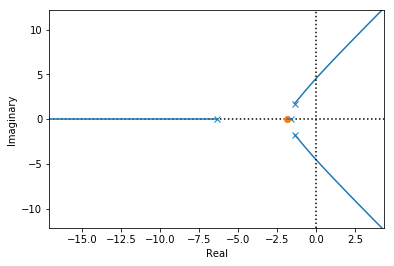

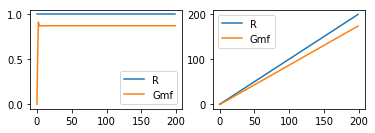

In [0]:
print("Malha Aberta")
CG_MA       = C * G_MA
print(f"C(s) * G(s) = {CG_MA}")

print("*********************************************")
print("Malha Fechada")
G_MF        = feedback(CG_MA, 1)
print(f"Gmf = {G_MF}")

print("*********************************************")
e_MF         = 1 - dcgain(G_MF)     #erro apos ser adicionado o controlador ao
print(f"e(∞) = {e_MF}")

print("*********************************************")

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MF     = stepinfo(G_MF)
print(f"stepinfo: ")
for info in infoG_MF:
  print(f"\t{info}: {infoG_MF[info]}")

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MF, step, t)
y_ramp = lsim(G_MF, ramp, t)
rlocusG_MF = rlocus(G_MF)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gmf"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gmf"])
plt.show()

# Controlador em avanço e atraso por lugar das raises
R━━━━━━ **+** → ▇ ━━━━━━→ C(s)━━━━━━→ G(s) ━━━━━━┳━━━━━━→Y\
....................**-**↑..............................................................┃\
.....................┃...............................................................┃\
.....................┃━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┃

Onde:
* o bloco C(s) é o compensador a ser desenvolvido. C(s) = Kc * (s+z)/(s+p)
* o bloco G(s) é a planta do sistema.
* R é o sinal de entrada do sistema (degrau, rampa, etc).
* Y é a resposta do sistema controlado prando a uma entrada R.

erro = e =  R - Y = (R * G(s) * C(s)) / (1+G(s) * C(s)) \
saida do controlador = u = e * C(s)\
Y = u * G = e * C(s) * G(s)\
Y/R = M(s) = (G(s) * C(s)) / (1+G(s) * C(s))

## Especificações de projeto
G(s) = 1 / ((s+5)*(s+1)*s) \
Especificações de MF: \
* ep(inf) <= 0.1  %erro no infinito 
* Mp%    <= 10    
* ts          <= 4 %segundos 
      
-----------------

G(s) = 4 / ((s+0.5)*s)  \
  Especificações de MF:
*    e(inf)   <= 0.0125   %erro no infinito
*    Mp%    <= 25   %overshoot
*    ts         <= 1.6     % segundos
-----------------


In [0]:
# Parametros da planta {G(s)}
Kp_MA           = 4
Numerador       = Kp_MA
Denominador     = np.convolve([1,0.5], [1,0])

# Especificações a serem alcançadas
ts_esp          = 1.6                                     # tempo de pico em segundos esperado
Mp_esp          = 25                                      # overshoot esperado em porcentagem
Mp_folga        = 5                                       # folga dada ao Mp, pq da aproximação de compensador para 2ª ordem
e_esp           = 0.0125                                  # Erro esperado no estado estacionario

## 1. Verificando comportamento em MA (Malha Aberta)

Gma=
     4
-----------
s^2 + 0.5 s

e(∞) = -inf
Polos de G(s) -> [-0.5  0. ]
Zeros de G(s) -> []
stepinfo: 
	RiseTime: 4.862862862862864
	SettlingTime: 6.901901901901902
	SettlingMin: 36.478010180622846
	SettlingMax: 40.483158134756444
	Overshoot: 0.0
	Undershoot: 0.0
	Peak: 40.483158134756444
	PeakTime: 7.0
	SteadyStateValue: 40.483158134756444


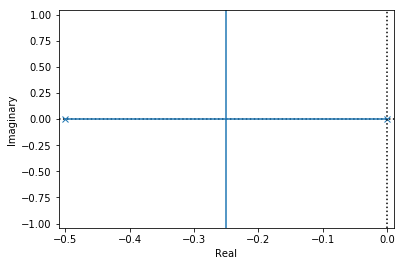

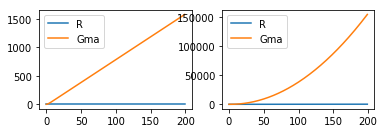

In [0]:
G_MA = tf(Numerador, Denominador)                          # FT em MA, C = 1
print(f"Gma={G_MA}")

e_MA = 1 - dcgain(G_MA)                                   # Erro da planta em MA
print(f"e(∞) = {e_MA}")

# Salva e exibe os polos e zeros da planta
polos_MA = pole(G_MA)
zeros_MA = zero(G_MA)
print(f"Polos de G(s) -> {polos_MA}")
print(f"Zeros de G(s) -> {zeros_MA}")

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MA = stepinfo(G_MA)
print(f"stepinfo: ")
for info in infoG_MA:
  print(f"\t{info}: {infoG_MA[info]}")

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MA, step, t)
y_ramp = lsim(G_MA, ramp, t)
rlocusG_MA = rlocus(G_MA)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gma"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gma"])
plt.show()

## 2. Determinando as especificações do compensador

In [0]:
# Determinando ganho do compensador, Kc
Kp_s    = symbols('Kp_s')
eq_Kp   = [(1/(1+Kp_s)) - e_esp]
Kp      = solve(eq_Kp, Kp_s)
Kp      = Kp[Kp_s]

print(f"Kp = {Kp}")
# Determinando o coeficiente de amortecimento, psi = ξ
psi     = np.arange(0, 1, 0.01)
MpVetor = 100*np.exp(((-1*psi*np.pi)/np.sqrt(1-psi**2)))
MpLoc   = np.where(MpVetor>=(Mp_esp-Mp_folga))[-1][-1] + 1
psi     = round(psi[MpLoc], 4)

print(f"ξ  = {psi}")


# Determinando a frequencia natural, Wn
Wn_s    = symbols('Wn_s')
eq_Wn   = [4/(psi*Wn_s)-ts_esp]
Wn      = solve(eq_Wn, Wn_s)
Wn      = round(Wn[Wn_s], 4)
# Wn      = 3 #%consideração feita devido a planta ser de 3ra ordem

print(f"Wn = {Wn}\t rad/s")

# Parametros de uma função de 2ª ordem
sigma   = psi * Wn
Wd      = Wn * np.sqrt(1-psi**2)

print(f"σ  = {sigma}")
print(f"Wd = {Wd}")

Kp = 79.0000000000000
ξ  = 0.46
Wn = 5.4348	 rad/s
σ  = 2.5000080000000002
Wd = 4.825661720420942


## 3. Determinando o polo e o zero do compensador

In [0]:
# Determinação do zero
  # a) polos dominantes do sistema
s = []
s.append(complex(-sigma, Wd))
s.append(complex(-sigma, -Wd))
  
  # b) determinando o polo
zero_c     = -sigma
# zero_c     = -0.5
print(f"Zero controlador -> {zero_c}")

# Determinação do polo
  # a) determinando theta, angulo entre o zero e o polo dominante
thetaZero   = np.arctan2(s[0].imag, s[0].real - zero_c.real)
thetaZeroD  = np.degrees(thetaZero)
print(f"Angulo entre o zero do controlador e o polo dominante = ϴ =")
print(f"\t= {round(thetaZeroD,4)}º = {round(thetaZero,4)} rad")

  # b) determinando phi pela condição de fase
phiPolo = []
textSum = "("

for k in range(len(polos_MA)):
  phiPolo.append(np.arctan2(s[0].imag, s[0].real - polos_MA[k]))
  print(f"φ{k} = {round(phiPolo[-1], 4)} rad")
  textSum += f"+ {round(np.degrees(phiPolo[-1]), 3)} "
textSum += ")"

phiPoloD    = np.degrees(phiPolo)
phiPolo_C   = (180 - np.sum(phiPoloD) + thetaZeroD)

print(f"Angulo entre o polo do controlador e o polo dominante = φ{len(polos_MA)} =")
print(f"\t= 180 - {textSum} + {round(thetaZeroD,3)} =")
print(f"\t= {round(phiPolo_C, 4)}º = {round(np.radians(phiPolo_C),4)} rad")

  # c) determinando localização do polo
d_s         = symbols('d_s')
eq_d        = [s[0].imag/d_s - np.tan(np.radians(phiPolo_C))]
d           = solve(eq_d, d_s)
polo_c      = -1*(d[d_s] + abs(sigma))
print(f"Polo controlador -> {polo_c}")

Zero controlador -> -2.5000080000000002
Angulo entre o zero do controlador e o polo dominante = ϴ =
	= 90.0º = 1.5708 rad
φ0 = 1.9637 rad
φ1 = 2.0488 rad
Angulo entre o polo do controlador e o polo dominante = φ2 =
	= 180 - (+ 112.512 + 117.387 ) + 90.0 =
	= 40.1012º = 0.6999 rad
Polo controlador -> -8.23042115162325


## 4. Determinar o ganho do controlador, Kc, usando a condição de módulo

In [0]:
h = []
for k in range(len(polos_MA)): 
  h.append(np.sqrt((Wd-abs(polos_MA[k].imag))**2 + (abs(sigma) - abs(polos_MA[k].real))**2))
h.append(np.sqrt(float(((Wd-0)**2 + (abs(sigma) - abs(polo_c))**2))))

c = sqrt((Wd-0)**2 + (abs(sigma) - abs(zero_c))**2)

Kc = np.prod(h) / (c*Kp_MA)

print(f"Kc  = {Kc}")

Kc  = 11.0184814771968


## 5. Monta controlador de avanço com os parametros determinados

In [0]:
numC    = np.array([1, -zero_c], dtype=float)
denC    = np.array([1, -polo_c], dtype=float)
C_adv   = tf(numC, denC)                     # Controlador em avanço
C       = tf(float(Kc)*numC, denC)           # Controlador em avanço com Kc
print(f"Control of advancement = Kc * (s+z)/(s+p) = ")
print(f"\t= {Kc} *  (s+z)/(s+p) = \t{C}")

Control of advancement = Kc * (s+z)/(s+p) = 
	= 11.0184814771968 *  (s+z)/(s+p) = 	
11.02 s + 27.55
---------------
    s + 8.23



## 6. Verifica o comportamento do sistema com o compensador de avanço

Malha Aberta
C(s) * G(s) = 
    44.07 s + 110.2
------------------------
s^3 + 8.73 s^2 + 4.115 s

*********************************************
Malha Fechada
Gmf = 
        44.07 s + 110.2
--------------------------------
s^3 + 8.73 s^2 + 48.19 s + 110.2

*********************************************
stepinfo: 
	RiseTime: 0.218617919041278
	SettlingTime: 1.530325433288946
	SettlingMin: 0.9068580270228088
	SettlingMax: 1.3888952933605507
	Overshoot: 39.04277685353941
	Undershoot: 0.0
	Peak: 1.3888952933605507
	PeakTime: 0.5745727359418203
	SteadyStateValue: 0.9988978390610987


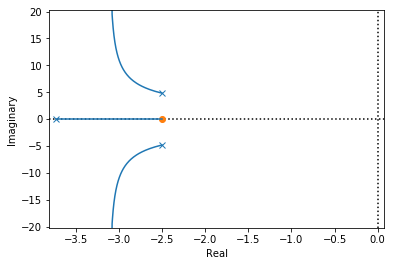

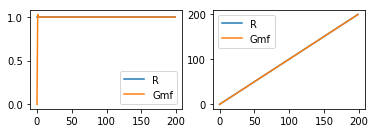

*********************************************
e(∞) = 0.03734813563656303


In [0]:
print("Malha Aberta")
CG_MA       = C * G_MA
print(f"C(s) * G(s) = {CG_MA}")

print("*********************************************")
print("Malha Fechada")
G_MF        = feedback(CG_MA, 1)
print(f"Gmf = {G_MF}")

print("*********************************************")

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MF     = stepinfo(G_MF)
print(f"stepinfo: ")
for info in infoG_MF:
  print(f"\t{info}: {infoG_MF[info]}")

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MF, step, t)
y_ramp = lsim(G_MF, ramp, t)
rlocusG_MF = rlocus(G_MF)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gmf"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gmf"])
plt.show()

print("*********************************************")
e_MF         = ramp[-1] - y_ramp[0][-1]     #erro apos ser adicionado o controlador ao
print(f"e(∞) = {e_MF}")


## 7. Determina os parametros do compensador de atraso e monta o compensador de atraso e avanço

In [0]:
# primeira opção de G(s)
# %Kp = lim {s * Kc * G(s) * (s+Z_c)/(s+P_c) * C_av} quando s tende a 0
# % 65.12476 * 1/5 *z/p* 0.5/8.43224 > 9
# % z/p>11.6535
# % p = 0.02
# % z > 0.2331
# C_lag = tf([1, 0.25],[1, 0.02])
# 11.593304 * 1/5 *z/p* 1.00002/2.680422 > 9
# z/p > 10.4034
# p = 0.02
# z > 0.2081
#C_lag = tf([1, 0.25],[1, 0.02])
# segunda opção de G(s)
# 11.018481 * 1/5 *z/p*  2.50/8.23042 > 79
# z/p > 118.0161
# p = 0.02
# z > 2.3603 
C_lag = tf([1, 2.4],[1, 0.02])
# Monta o controlador em atraso e avanço
C = float(Kc) * C_lag * C_adv

## 8. Verifica o comportamento do sistema com o compensador de avanço e atraso

Malha Aberta
C(s) * G(s) = 
      44.07 s^2 + 216 s + 264.4
------------------------------------
s^4 + 8.75 s^3 + 4.29 s^2 + 0.0823 s

*********************************************
Malha Fechada
Gmf = 
        44.07 s^2 + 216 s + 264.4
------------------------------------------
s^4 + 8.75 s^3 + 48.36 s^2 + 216 s + 264.4

*********************************************
stepinfo: 
	RiseTime: 0.18432807751084945
	SettlingTime: 5.419245478818973
	SettlingMin: 0.451436489460253
	SettlingMax: 1.8099334273813388
	Overshoot: 80.90516141619969
	Undershoot: 0.0
	Peak: 1.8099334273813388
	PeakTime: 0.5437678286570058
	SteadyStateValue: 1.0004874450305556


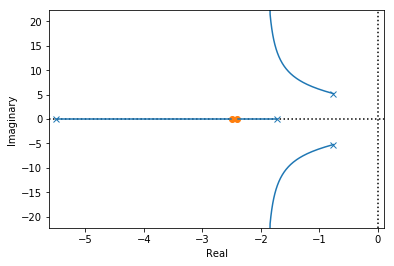

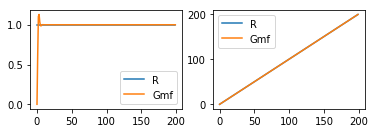

*********************************************
e(∞) = 0.00031123446370884267


In [0]:
print("Malha Aberta")
CG_MA       = C * G_MA
print(f"C(s) * G(s) = {CG_MA}")

print("*********************************************")
print("Malha Fechada")
G_MF        = feedback(CG_MA, 1)
print(f"Gmf = {G_MF}")

print("*********************************************")

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MF     = stepinfo(G_MF)
print(f"stepinfo: ")
for info in infoG_MF:
  print(f"\t{info}: {infoG_MF[info]}")

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MF, step, t)
y_ramp = lsim(G_MF, ramp, t)
rlocusG_MF = rlocus(G_MF)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gmf"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gmf"])
plt.show()

print("*********************************************")
e_MF         = ramp[-1] - y_ramp[0][-1]     #erro apos ser adicionado o controlador ao
print(f"e(∞) = {e_MF}")


# Controlador em avanço por resposta em frequencia
R━━━━━━ **+** → ▇ ━━━━━━→ C(s)━━━━━━→ G(s) ━━━━━━┳━━━━━━→Y\
....................**-**↑..............................................................┃\
.....................┃...............................................................┃\
.....................┃━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┃

Onde:
* o bloco C(s) é o compensador a ser desenvolvido. C(s) = Kc * (T*s+1)/(T*a*s+1) onde  0<a<1
* o bloco G(s) é a planta do sistema.
* R é o sinal de entrada do sistema (degrau, rampa, etc).
* Y é a resposta do sistema controlado prando a uma entrada R.

erro = e =  R - Y = (R * G(s) * C(s)) / (1+G(s) * C(s)) \
saida do controlador = u = e * C(s)\
Y = u * G = e * C(s) * G(s)\
Y/R = M(s) = (G(s) * C(s)) / (1+G(s) * C(s))

## Especificações de projeto
G(s) = 5 / ((s+1)*s)  \
  Especificações de MF:
*    e(inf) <= 0.02  %erro no infinito
*    MFd = 50        % em graus, margem de fase desejada

-----------------


In [0]:
# Parametros da planta {G(s)}
Kp_MA           = 5
Numerador       = Kp_MA
Denominador     = np.convolve([1,1], [1, 0])

# Especificações a serem alcançadas
MFd             = 50;                                     # em graus, margem de fase desejada
MFseg           = 3;                                      # margem de fase de segurança, variavel
e_esp           = 0.02                                    # Erro esperado no estado estacionario

## 1. Verificando comportamento em MA (Malha Aberta)

Gma=
   5
-------
s^2 + s

e(∞) = -inf
Polos de G(s) -> [-1.  0.]
Zeros de G(s) -> []
stepinfo: 
	RiseTime: 5.066066066066067
	SettlingTime: 6.880880880880881
	SettlingMin: 27.030293298000124
	SettlingMax: 30.00455940982897
	Overshoot: 0.0
	Undershoot: 0.0
	Peak: 30.00455940982897
	PeakTime: 7.0
	SteadyStateValue: 30.00455940982897


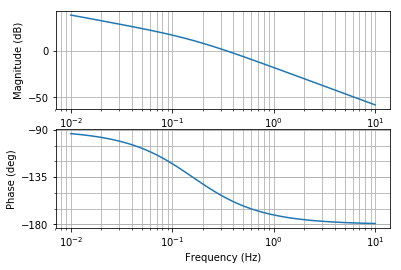

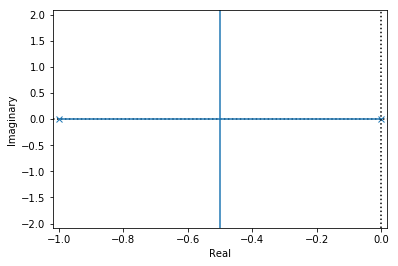

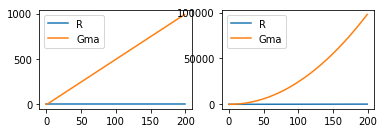

In [0]:
G_MA = tf(Numerador, Denominador)                          # FT em MA, C = 1
print(f"Gma={G_MA}")

e_MA = 1 - dcgain(G_MA)                                   # Erro da planta em MA
print(f"e(∞) = {e_MA}")

# Salva e exibe os polos e zeros da planta
polos_MA = pole(G_MA)
zeros_MA = zero(G_MA)
print(f"Polos de G(s) -> {polos_MA}")
print(f"Zeros de G(s) -> {zeros_MA}")

# Salva os dados de resposta em frequencia
[mag,phase,wout] = bode(G_MA);

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MA = stepinfo(G_MA)
print(f"stepinfo: ")
for info in infoG_MA:
  print(f"\t{info}: {infoG_MA[info]}")

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MA, step, t)
y_ramp = lsim(G_MA, ramp, t)
rlocusG_MA = rlocus(G_MA)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gma"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gma"])
plt.show()

## 2. Determinando as especificações do compensador

In [0]:
# Determinando ganho do compensador, Kc
Kv_min  = 1 / e_esp
Kp      = Kp_MA

Kc      = Kv_min / Kp

print(f"Kc = {Kc}")

Kc = 10.0


## 3. Avaliação do comportamento do sistema sendo C(s) = Kc

φ_max = 44.91071830650196


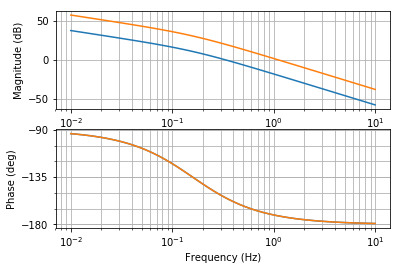

In [0]:
Cav                  = Kc
Gma_Cav              = G_MA*Kc
bode(G_MA)
bode(Gma_Cav)

[gm, pm, wcg, wcp]   = margin(Gma_Cav)             # Verificando a MF e MG do sistema, MF= margem de fase, MG = margem de ganho
MFkc                 = pm;                         # margem de fase após o Kc
phiMax               = MFd - MFkc + MFseg          # em graus
print(f"φ_max = {phiMax}")

## 4. Determina o valor a do compensador

In [0]:
a = (1-np.sin(np.radians(phiMax)))/(1+np.sin(np.radians(phiMax)))
print(f"a = {a}")

a = 0.17233014760294005


## 5.  Determinar a localização da resposnta em frequencia (RF) do compensador, Wm


In [0]:
C_jwm = 20 * np.log10(Kc/np.sqrt(a))        # em Db

magDb = 20 * np.log10(mag)

# % Lugar em que cruzar pela reta [-C_jwm -C_jwm] é referente a frequencia Wm
  # % encontra o ponto de cruzamento
magDbLoc  = np.where(magDb >= -float(C_jwm))[-1][-1]
Wm        = round(wout[magDbLoc], 4)
print(f"C(jWm) = {C_jwm}")
print(f"Wm = {Wm}")

C(jWm) = 27.636387400082274
Wm = 10.0522


## 6. Determinar do parametro T do compensador

In [0]:
T = 1 /(np.sqrt(a)*Wm)
print(f"T = {T}")

T = 0.2396394141606799


## 7. Monta controlador com os parametros determinados

In [0]:
numC    = np.array([T, 1], dtype=float)
denC    = np.array([T*a, 1], dtype=float)
C       = tf(float(Kc)*numC, denC)           # Controlador m avanço
print(f"Control of advancement = Kc * (T*s+1)/(T*a*s+1) = ")
print(f"\t= {Kc} *  ({round(T,2)}*s+1)/({round(T,2)}*{round(a,2)}*s+1) = \t{C}")

Control of advancement = Kc * (T*s+1)/(T*a*s+1) = 
	= 10.0 *  (0.24*s+1)/(0.24*0.17*s+1) = 	
2.396 s + 10
------------
0.0413 s + 1



## 8. Verifica o comportamento do sistema com o compensador

Malha Aberta
C(s) * G(s) = 
       11.98 s + 50
--------------------------
0.0413 s^3 + 1.041 s^2 + s

*********************************************
Malha Fechada
Gmf = 
            11.98 s + 50
-------------------------------------
0.0413 s^3 + 1.041 s^2 + 12.98 s + 50

*********************************************


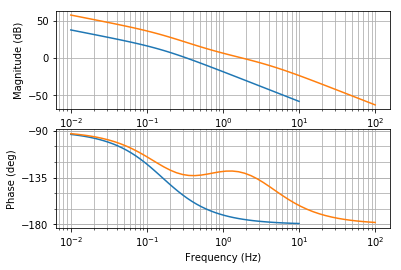

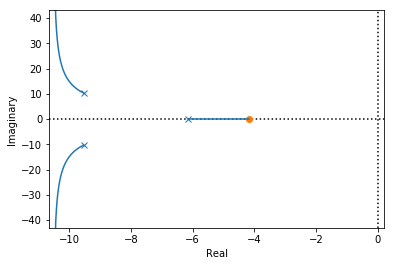

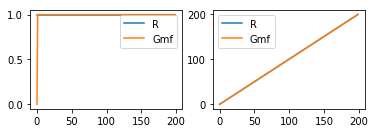

*********************************************
e(∞) = 0.020000000000180762


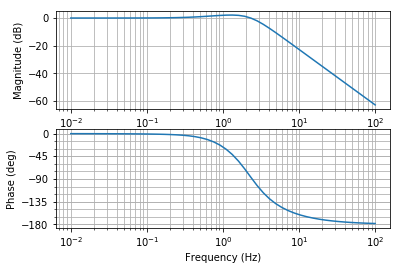

In [0]:
print("Malha Aberta")
CG_MA       = C * G_MA
print(f"C(s) * G(s) = {CG_MA}")

print("*********************************************")
print("Malha Fechada")
G_MF        = feedback(CG_MA, 1)
print(f"Gmf = {G_MF}")

print("*********************************************")

# Verifica as informações do sistema perante a uma entrada degrau
# infoG_MF     = stepinfo(G_MF)
# print(f"stepinfo: ")
# for info in infoG_MF:
#   print(f"\t{info}: {infoG_MF[info]}")

# Verifica a resposta em frequencia
bode(G_MA)
bode(CG_MA)

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MF, step, t)
y_ramp = lsim(G_MF, ramp, t)
rlocusG_MF = rlocus(G_MF)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gmf"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gmf"])
plt.show()

bode(G_MF)

print("*********************************************")
e_MF         = ramp[-1] - y_ramp[0][-1]     #erro apos ser adicionado o controlador ao
print(f"e(∞) = {e_MF}")


# Controlador em atraso por resposta em frequencia
R━━━━━━ **+** → ▇ ━━━━━━→ C(s)━━━━━━→ G(s) ━━━━━━┳━━━━━━→Y\
....................**-**↑..............................................................┃\
.....................┃...............................................................┃\
.....................┃━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┃

Onde:
* o bloco C(s) é o compensador a ser desenvolvido. C(s) = Kc * (T*s+1)/(T*a*s+1) onde  a>1
* o bloco G(s) é a planta do sistema.
* R é o sinal de entrada do sistema (degrau, rampa, etc).
* Y é a resposta do sistema controlado prando a uma entrada R.

erro = e =  R - Y = (R * G(s) * C(s)) / (1+G(s) * C(s)) \
saida do controlador = u = e * C(s)\
Y = u * G = e * C(s) * G(s)\
Y/R = M(s) = (G(s) * C(s)) / (1+G(s) * C(s))

## Especificações de projeto
G(s) = 1 / ((s+1)*s)  \
  Especificações de MF:
*    e(inf) <= 0.02  %erro no infinito
*   50 < MFd < 60        % em graus, margem de fase desejada

-----------------


In [0]:
# Parametros da planta {G(s)}
Kp_MA           = 1
Numerador       = Kp_MA
Denominador     = np.convolve([1,1], [1, 0])

# Especificações a serem alcançadas
MFd             = 50;                                     # em graus, margem de fase desejada
MFseg           = 5;                                      # margem de fase de segurança, variavel
e_esp           = 0.02                                    # Erro esperado no estado estacionario

## 1. Verificando comportamento em MA (Malha Aberta)

Gma=
   1
-------
s^2 + s

e(∞) = -inf
Polos de G(s) -> [-1.  0.]
Zeros de G(s) -> []
stepinfo: 
	RiseTime: 5.066066066066067
	SettlingTime: 6.880880880880881
	SettlingMin: 5.406058659600025
	SettlingMax: 6.000911881965794
	Overshoot: 0.0
	Undershoot: 0.0
	Peak: 6.000911881965794
	PeakTime: 7.0
	SteadyStateValue: 6.000911881965794


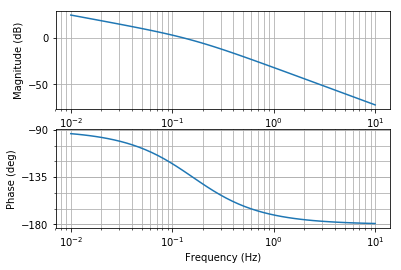

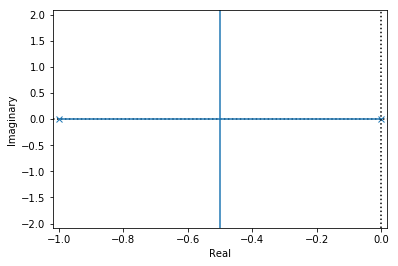

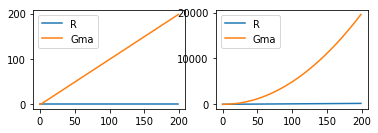

In [0]:
G_MA = tf(Numerador, Denominador)                          # FT em MA, C = 1
print(f"Gma={G_MA}")

e_MA = 1 - dcgain(G_MA)                                   # Erro da planta em MA
print(f"e(∞) = {e_MA}")

# Salva e exibe os polos e zeros da planta
polos_MA = pole(G_MA)
zeros_MA = zero(G_MA)
print(f"Polos de G(s) -> {polos_MA}")
print(f"Zeros de G(s) -> {zeros_MA}")

# Salva os dados de resposta em frequencia
[mag,phase,wout] = bode(G_MA);

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MA = stepinfo(G_MA)
print(f"stepinfo: ")
for info in infoG_MA:
  print(f"\t{info}: {infoG_MA[info]}")

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MA, step, t)
y_ramp = lsim(G_MA, ramp, t)
rlocusG_MA = rlocus(G_MA)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gma"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gma"])
plt.show()

## 2. Determinando as especificações do compensador

In [0]:
# Determinando ganho do compensador, Kc
Kv_min  = 1 / e_esp
Kp      = Kp_MA

Kc      = Kv_min / Kp

print(f"Kc = {Kc}")

Kc = 50.0


## 3. Avaliação do comportamento do sistema sendo C(s) = Kc

φ_max = 46.91071830650196


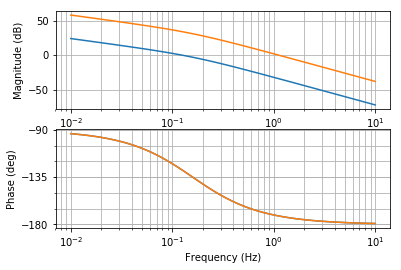

In [0]:
C_lag                = Kc
Gma_Clag             = G_MA*Kc
bode(G_MA)
bode(Gma_Clag)

[gm, pm, wcg, wcp]   = margin(Gma_Clag)             # Verificando a MF e MG do sistema, MF= margem de fase, MG = margem de ganho
MFkc                 = pm;                         # margem de fase após o Kc
phiMax               = MFd - MFkc + MFseg          # em graus
print(f"φ_max = {phiMax}")

## 4.  Determinar a localização da resposnta em frequencia (RF) do compensador, Wm


In [0]:
C_jwm = 20 * np.log10(Kc/np.sqrt(a))        # em Db

magDb = 20 * np.log10(mag)

# % Lugar em que cruzar pela reta [-C_jwm -C_jwm] é referente a frequencia Wm
  # % encontra o ponto de cruzamento
phaseLoc  = np.where(180+np.degrees(phase) <= (MFseg+MFd))[-1][0] - 1  #primeiro seleciona o array (só retorna 1), depois seleciona qual item (0 ==first, -1 == last)
Wcd       = round(wout[phaseLoc], 4)
print(f"C(jWm) = {C_jwm}")
print(f"Wcd = {Wcd}")

C(jWm) = 41.615787486802645
Wcd = 0.6902


## 5. Determina o valor a do compensador

a = 59.56808794080842


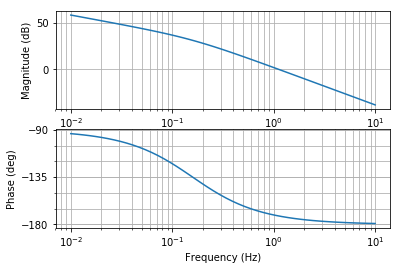

In [0]:
[mag_Clag,phase_Clag,wout_Clag] = bode(Gma_Clag);
magDb_Cat                       = 20*np.log10(mag_Clag);
wLoc                            = np.where(wout >= Wcd)[-1][-1]-1
KcG_WCD                         = magDb_Cat[wLoc]
a                               = 10**(abs(KcG_WCD)/20)
print(f"a = {a}")

## 6. Determinar do parametro T do compensador

In [0]:
T = 10 /(Wcd)
print(f"T = {T}")

T = 14.488554042306577


## 7. Monta controlador com os parametros determinados

In [0]:
numC    = np.array([T, 1], dtype=float)
denC    = np.array([T*a, 1], dtype=float)
C       = tf(float(Kc)*numC, denC)           # Controlador em atraso
print(f"Control of lag = Kc * (T*s+1)/(T*a*s+1) = ")
print(f"\t= {Kc} *  ({round(T,2)}*s+1)/({round(T,2)}*{round(a,2)}*s+1) = \t{C}")

Control of lag = Kc * (T*s+1)/(T*a*s+1) = 
	= 50.0 *  (14.49*s+1)/(14.49*59.57*s+1) = 	
724.4 s + 50
------------
863.1 s + 1



## 8. Verifica o comportamento do sistema com o compensador

Malha Aberta
C(s) * G(s) = 
      724.4 s + 50
-------------------------
863.1 s^3 + 864.1 s^2 + s

*********************************************
Malha Fechada
Gmf = 
            724.4 s + 50
------------------------------------
863.1 s^3 + 864.1 s^2 + 725.4 s + 50

*********************************************
stepinfo: 
	RiseTime: 1.7716584101309185
	SettlingTime: 20.980165383129297
	SettlingMin: 0.9188913779987699
	SettlingMax: 1.2266973733005242
	Overshoot: 22.65891193674696
	Undershoot: 0.0
	Peak: 1.2266973733005242
	PeakTime: 4.196033076625859
	SteadyStateValue: 1.0000882560682671


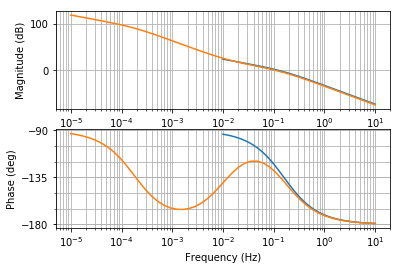

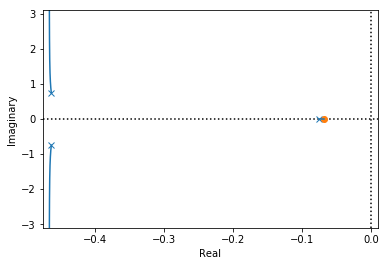

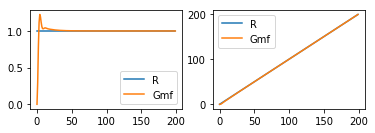

*********************************************
e(∞) = 0.020000412507897636


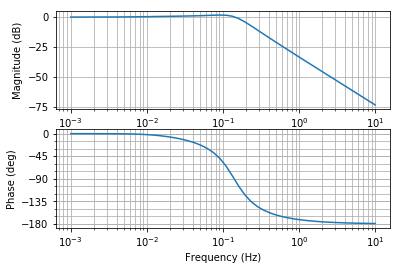

In [0]:
print("Malha Aberta")
CG_MA       = C * G_MA
print(f"C(s) * G(s) = {CG_MA}")

print("*********************************************")
print("Malha Fechada")
G_MF        = feedback(CG_MA, 1)
print(f"Gmf = {G_MF}")

print("*********************************************")

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MF     = stepinfo(G_MF)
print(f"stepinfo: ")
for info in infoG_MF:
  print(f"\t{info}: {infoG_MF[info]}")

# Verifica a resposta em frequencia
bode(G_MA)
bode(CG_MA)

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MF, step, t)
y_ramp = lsim(G_MF, ramp, t)
rlocusG_MF = rlocus(G_MF)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gmf"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gmf"])
plt.show()

bode(G_MF)

print("*********************************************")
e_MF         = ramp[-1] - y_ramp[0][-1]     #erro apos ser adicionado o controlador ao
print(f"e(∞) = {e_MF}")


# Controlador Proporcional Integrador (PI) por alocação dos polos
R━━━━━━ **+** → ▇ ━━━━━━→ C(s)━━━━━━→ G(s) ━━━━━━┳━━━━━━→Y\
....................**-**↑..............................................................┃\
.....................┃...............................................................┃\
.....................┃━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┃

Onde:
* o bloco C(s) é o compensador a ser desenvolvido. C(s) = Kc * (1+ 1 / (Ti *s)) = Kc * ((Ti*s+ 1) / (Ti *s))
* o bloco G(s) é a planta do sistema.
* R é o sinal de entrada do sistema (degrau, rampa, etc).
* Y é a resposta do sistema controlado prando a uma entrada R.

erro = e =  R - Y = (R * G(s) * C(s)) / (1+G(s) * C(s)) \
saida do controlador = u = e * C(s)\
Y = u * G = e * C(s) * G(s)\
Y/R = M(s) = (G(s) * C(s)) / (1+G(s) * C(s))

## Especificações de projeto
G(s) = 1 / ((10*s+1))  \
  Especificações de MF:
*   Mp < 10
*   tau_mf = 2
*   ts = 4 * tau_mf

-----------------


In [0]:
# Parametros da planta {G(s)}
Kp_MA           = 1
Numerador       = Kp_MA
tau_MA          = 10
Denominador     = np.array([tau_MA, 1], dtype=float)

# Especificações a serem alcançadas
Mp_esp          = 2                                       # overshoot esperado em porcentagem
Mp_folga        = 1                                       # folga dada ao Mp, pq da aproximação de compensador para 2ª ordem
tauMF_esp       = 5                                       # tau em MF
ts_esp          = 4*tauMF_esp

## 1. Verificando comportamento em MA (Malha Aberta)

Gma=
    1
--------
10 s + 1

e(∞) = 0.0
Polos de G(s) -> [-0.1]
Zeros de G(s) -> []
stepinfo: 
	RiseTime: 21.861861861861865
	SettlingTime: 38.74874874874875
	SettlingMin: 0.8995704003856295
	SettlingMax: 0.9990881180344431
	Overshoot: 0.0
	Undershoot: 0.0
	Peak: 0.9990881180344431
	PeakTime: 70.0
	SteadyStateValue: 0.9990881180344431


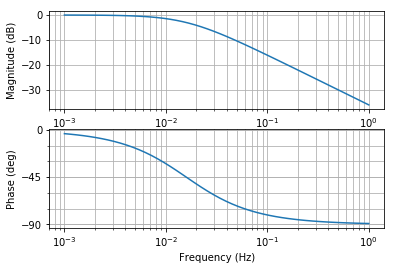

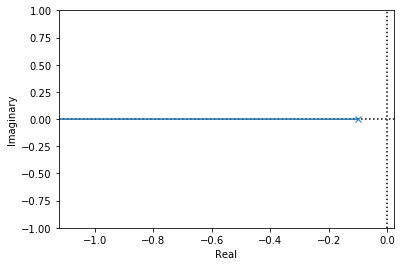

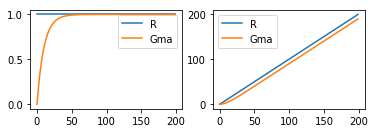

In [0]:
G_MA = tf(Numerador, Denominador)                          # FT em MA, C = 1
print(f"Gma={G_MA}")

e_MA = 1 - dcgain(G_MA)                                   # Erro da planta em MA
print(f"e(∞) = {e_MA}")

# Salva e exibe os polos e zeros da planta
polos_MA = pole(G_MA)
zeros_MA = zero(G_MA)
print(f"Polos de G(s) -> {polos_MA}")
print(f"Zeros de G(s) -> {zeros_MA}")

# Salva os dados de resposta em frequencia
[mag,phase,wout] = bode(G_MA);

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MA = stepinfo(G_MA)
print(f"stepinfo: ")
for info in infoG_MA:
  print(f"\t{info}: {infoG_MA[info]}")

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MA, step, t)
y_ramp = lsim(G_MA, ramp, t)
rlocusG_MA = rlocus(G_MA)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gma"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gma"])
plt.show()

## 2. Determinar parametros do compensador

In [0]:
# Determinando o coeficiente de amortecimento, psi = ξ
psi     = np.arange(0, 1, 0.01)
MpVetor = 100*np.exp(((-1*psi*np.pi)/np.sqrt(1-psi**2)))
MpLoc   = np.where(MpVetor>=(Mp_esp-Mp_folga))[-1][-1] + 1
psi     = round(psi[MpLoc], 4)

print(f"ξ  = {psi}")

# Determinando a frequencia natural, Wn
Wn_s    = symbols('Wn_s')
eq_Wn   = [4/(psi*Wn_s)-ts_esp]
Wn      = solve(eq_Wn, Wn_s)
Wn      = round(Wn[Wn_s], 4)

print(f"Wn = {Wn}\t rad/s")

# Parametros de uma função de 2ª ordem
sigma   = psi * Wn
Wd      = Wn * np.sqrt(1-psi**2)

print(f"σ  = {sigma}")
print(f"Wd = {Wd}")

ξ  = 0.83
Wn = 0.241	 rad/s
σ  = 0.20002999999999999
Wd = 0.13442097715758503


## 3. Determinar equação caracteristica em MF   (Somete denominador)

In [0]:
eqc_MF = tf(1, np.array([1,2*psi*Wn,Wn**2], dtype=float))
print(f"Eqc_MF = {eqc_MF}")

Eqc_MF = 
            1
------------------------
s^2 + 0.4001 s + 0.05808



## 4. Projetando o compensador PI

In [0]:
# parametros do compensador
Kc = (2 * psi * Wn * tau_MA - 1) / Kp_MA
Ti = (2 * psi * Wn * tau_MA - 1) / (tau_MA*Wn**2)

print(f"Kc = {Kc}")
print(f"Ti = {Ti}")

# Compensador PI
C = tf(np.array([Ti,1], dtype=float), np.array([Ti,0], dtype=float))

print(f"C = {C}")

Kc = 3.0005999999999995
Ti = 5.1662333637506235
C = 
5.166 s + 1
-----------
  5.166 s



## 5. Verifica o comportamento do sistema com o compensador

Malha Aberta
C(s) * G(s) = 
    5.166 s + 1
-------------------
51.66 s^2 + 5.166 s

*********************************************
Malha Fechada
Gmf = 
      5.166 s + 1
-----------------------
51.66 s^2 + 10.33 s + 1

*********************************************
stepinfo: 
	RiseTime: 11.491491491491493
	SettlingTime: 38.04804804804805
	SettlingMin: 0.9001490039844368
	SettlingMax: 1.0619040818047605
	Overshoot: 6.2760148173261046
	Undershoot: 0.0
	Peak: 1.0619040818047605
	PeakTime: 24.174174174174176
	SteadyStateValue: 0.9991944877026373
Rlocus de C(s) * G(s):


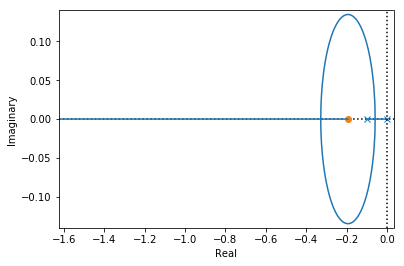

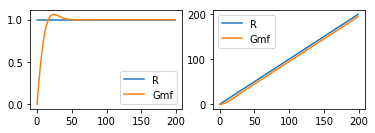

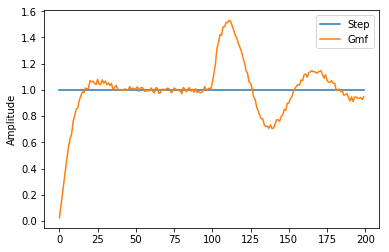

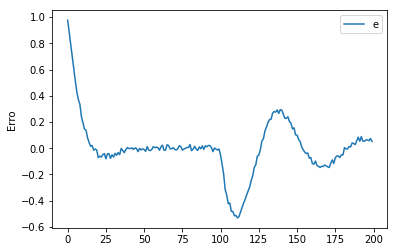

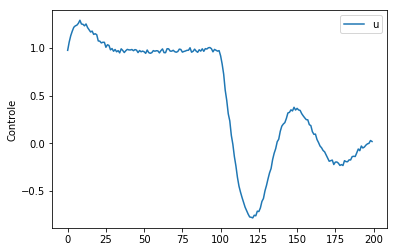

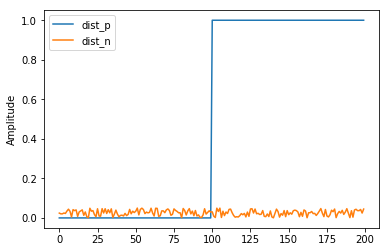

*********************************************
e(∞) = 5.166233357336466
*********************************************
Rlocus de gmf


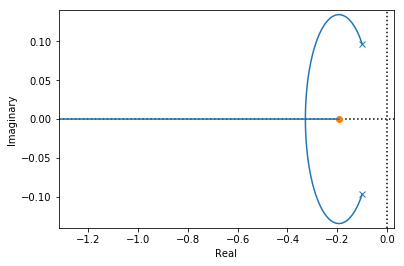

In [0]:
print("Malha Aberta")
CG_MA       = C * G_MA
print(f"C(s) * G(s) = {CG_MA}")

print("*********************************************")
print("Malha Fechada")
G_MF        = feedback(CG_MA, 1)
print(f"Gmf = {G_MF}")

print("*********************************************")

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MF     = stepinfo(G_MF)
print(f"stepinfo: ")
for info in infoG_MF:
  print(f"\t{info}: {infoG_MF[info]}")

# Verifica a resposta em frequencia
# bode(G_MA)
# bode(CG_MA)
print("Rlocus de C(s) * G(s):")
rlocusCG_MA = rlocus(CG_MA)
# resposta perante a entrada e root locus da planta
y_step = lsim(G_MF, step, t)
y_ramp = lsim(G_MF, ramp, t)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gmf"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gmf"])
plt.show()

# monta o sistema em MF com perturbações
Gmf         = feedback(CG_MA, 1);
Gd1         = feedback(G_MA, CG_MA);         # perturbação entre o controlador e a planta
Gd2         = feedback(1, CG_MA);           # pertubação na saida da planta

# verifica a resposta do sistema frente a um step
yma_step    = lsim(G_MA, step, t);
ymf_step    = lsim(G_MF, step, t);
yd1_step    = lsim(Gd1, dist_p, t);
yd2_step    = lsim(Gd2, dist_n, t);
y_step      = ymf_step[0]+yd1_step[0]+yd2_step[0]

# ----- calculo do erro
yr = step;
er = yr-y_step;
u = lsim(C, er, t);
plt.plot(t, step)
plt.plot(t, y_step)
plt.legend(["Step", "Gmf"])
plt.ylabel("Amplitude")
plt.show()
plt.plot(t, er)
plt.legend("e")
plt.ylabel("Erro")
plt.show()
plt.plot(t, u[0])
plt.legend("u")
plt.ylabel("Controle")
plt.show()
plt.plot(t, dist_p)
plt.plot(t, dist_n)
plt.legend(["dist_p", "dist_n"])
plt.ylabel("Amplitude")
plt.show()
print("*********************************************")
e_MF         = ramp[-1] - y_ramp[0][-1]     #erro apos ser adicionado o controlador ao
print(f"e(∞) = {e_MF}")
print("*********************************************")
print("Rlocus de gmf")
rlocusG_MF = rlocus(G_MF)

# Controlador Proporcional Integrador (PI) por cancelamento dos polos
R━━━━━━ **+** → ▇ ━━━━━━→ C(s)━━━━━━→ G(s) ━━━━━━┳━━━━━━→Y\
....................**-**↑..............................................................┃\
.....................┃...............................................................┃\
.....................┃━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┃

Onde:
* o bloco C(s) é o compensador a ser desenvolvido. C(s) = Kc * (1+ 1 / (Ti *s)) = Kc * ((Ti*s+ 1) / (Ti *s))
* o bloco G(s) é a planta do sistema.
* R é o sinal de entrada do sistema (degrau, rampa, etc).
* Y é a resposta do sistema controlado prando a uma entrada R.

erro = e =  R - Y = (R * G(s) * C(s)) / (1+G(s) * C(s)) \
saida do controlador = u = e * C(s)\
Y = u * G = e * C(s) * G(s)\
Y/R = M(s) = (G(s) * C(s)) / (1+G(s) * C(s))

## Especificações de projeto
G(s) = 1 / ((10*s+1))  \
  Especificações de MF:
*   Mp < 10
*   tau_mf = 2
*   ts = 4 * tau_mf

-----------------


In [0]:
# Parametros da planta {G(s)}
Kp_MA           = 1
Numerador       = Kp_MA
tau_MA          = 10
Denominador     = np.array([tau_MA, 1], dtype=float)

# Especificações a serem alcançadas
Mp_esp          = 2                                       # overshoot esperado em porcentagem
Mp_folga        = 1                                       # folga dada ao Mp, pq da aproximação de compensador para 2ª ordem
tauMF_esp       = 5                                       # tau em MF
ts_esp          = 4*tauMF_esp

## 1. Verificando comportamento em MA (Malha Aberta)

Gma=
    1
--------
10 s + 1

e(∞) = 0.0
Polos de G(s) -> [-0.1]
Zeros de G(s) -> []
stepinfo: 
	RiseTime: 21.861861861861865
	SettlingTime: 38.74874874874875
	SettlingMin: 0.8995704003856295
	SettlingMax: 0.9990881180344431
	Overshoot: 0.0
	Undershoot: 0.0
	Peak: 0.9990881180344431
	PeakTime: 70.0
	SteadyStateValue: 0.9990881180344431


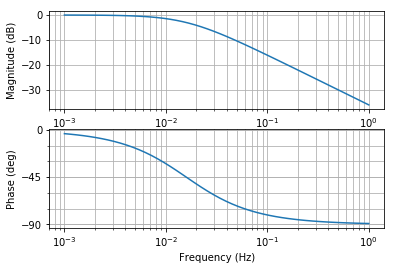

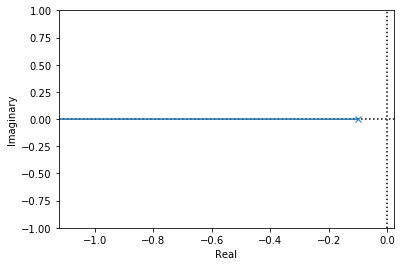

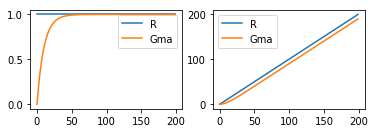

In [0]:
G_MA = tf(Numerador, Denominador)                          # FT em MA, C = 1
print(f"Gma={G_MA}")

e_MA = 1 - dcgain(G_MA)                                   # Erro da planta em MA
print(f"e(∞) = {e_MA}")

# Salva e exibe os polos e zeros da planta
polos_MA = pole(G_MA)
zeros_MA = zero(G_MA)
print(f"Polos de G(s) -> {polos_MA}")
print(f"Zeros de G(s) -> {zeros_MA}")

# Salva os dados de resposta em frequencia
[mag,phase,wout] = bode(G_MA);

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MA = stepinfo(G_MA)
print(f"stepinfo: ")
for info in infoG_MA:
  print(f"\t{info}: {infoG_MA[info]}")

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MA, step, t)
y_ramp = lsim(G_MA, ramp, t)
rlocusG_MA = rlocus(G_MA)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gma"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gma"])
plt.show()

## 2. Determinar parametros do compensador

In [0]:
lmbda = 0.5      # rapido
# % lambda = 1   %igual
# % lambda = 2   %lento

## 3. Projetando o compensador PI

In [0]:
# parametros do compensador
Kc = 1/(lmbda*Kp_MA)
Ti = tau_MA

print(f"Kc = {Kc}")
print(f"Ti = {Ti}")

# Compensador PI
C = tf(np.array([Ti,1], dtype=float), np.array([Ti,0], dtype=float))

print(f"C = {C}")

Kc = 2.0
Ti = 10
C = 
10 s + 1
--------
  10 s



## 4. Verifica o comportamento do sistema com o compensador

Malha Aberta
C(s) * G(s) = 
   10 s + 1
--------------
100 s^2 + 10 s

*********************************************
Malha Fechada
Gmf = 
     10 s + 1
------------------
100 s^2 + 20 s + 1

*********************************************
stepinfo: 
	RiseTime: 21.861861861861865
	SettlingTime: 38.74874874874875
	SettlingMin: 0.8995704003856428
	SettlingMax: 0.9990881180344549
	Overshoot: 0.0
	Undershoot: 0.0
	Peak: 0.9990881180344549
	PeakTime: 70.0
	SteadyStateValue: 0.9990881180344549
Rlocus de C(s) * G(s):


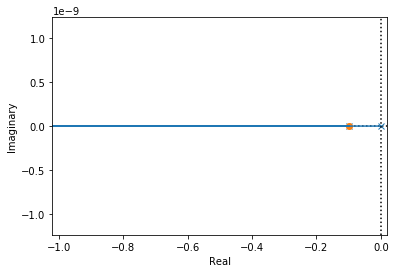

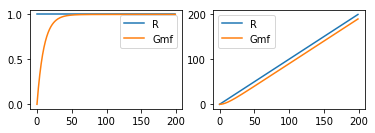

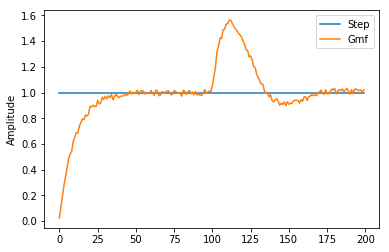

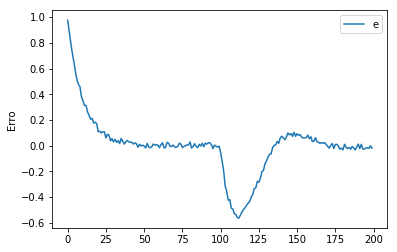

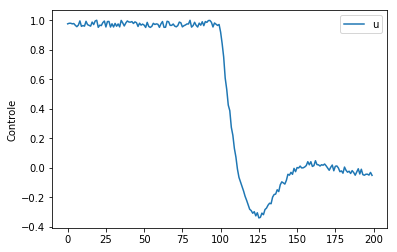

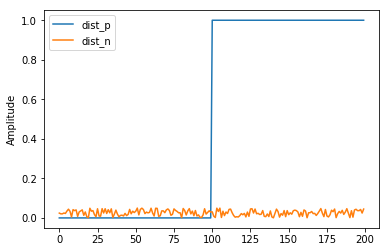

*********************************************
e(∞) = 9.999999977220597
*********************************************
Rlocus de gmf


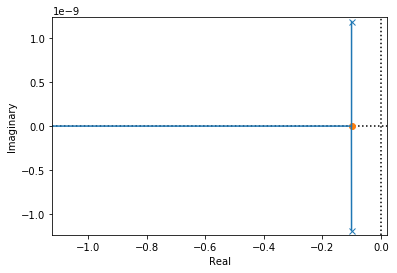

In [0]:
print("Malha Aberta")
CG_MA       = C * G_MA
print(f"C(s) * G(s) = {CG_MA}")

print("*********************************************")
print("Malha Fechada")
G_MF        = feedback(CG_MA, 1)
print(f"Gmf = {G_MF}")

print("*********************************************")

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MF     = stepinfo(G_MF)
print(f"stepinfo: ")
for info in infoG_MF:
  print(f"\t{info}: {infoG_MF[info]}")

# Verifica a resposta em frequencia
# bode(G_MA)
# bode(CG_MA)
print("Rlocus de C(s) * G(s):")
rlocusCG_MA = rlocus(CG_MA)
# resposta perante a entrada e root locus da planta
y_step = lsim(G_MF, step, t)
y_ramp = lsim(G_MF, ramp, t)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gmf"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gmf"])
plt.show()

# monta o sistema em MF com perturbações
Gmf         = feedback(CG_MA, 1);
Gd1         = feedback(G_MA, CG_MA);         # perturbação entre o controlador e a planta
Gd2         = feedback(1, CG_MA);           # pertubação na saida da planta

# verifica a resposta do sistema frente a um step
yma_step    = lsim(G_MA, step, t);
ymf_step    = lsim(G_MF, step, t);
yd1_step    = lsim(Gd1, dist_p, t);
yd2_step    = lsim(Gd2, dist_n, t);
y_step      = ymf_step[0]+yd1_step[0]+yd2_step[0]

# ----- calculo do erro
yr = step;
er = yr-y_step;
u = lsim(C, er, t);
plt.plot(t, step)
plt.plot(t, y_step)
plt.legend(["Step", "Gmf"])
plt.ylabel("Amplitude")
plt.show()
plt.plot(t, er)
plt.legend("e")
plt.ylabel("Erro")
plt.show()
plt.plot(t, u[0])
plt.legend("u")
plt.ylabel("Controle")
plt.show()
plt.plot(t, dist_p)
plt.plot(t, dist_n)
plt.legend(["dist_p", "dist_n"])
plt.ylabel("Amplitude")
plt.show()
print("*********************************************")
e_MF         = ramp[-1] - y_ramp[0][-1]     #erro apos ser adicionado o controlador ao
print(f"e(∞) = {e_MF}")
print("*********************************************")
print("Rlocus de gmf")
rlocusG_MF = rlocus(G_MF)

# Controlador Proporcional Integrador Derivador (PID) por alocamento dos polos
R━━━━━━ **+** → ▇ ━━━━━━→ C(s)━━━━━━→ G(s) ━━━━━━┳━━━━━━→Y\
....................**-**↑..............................................................┃\
.....................┃...............................................................┃\
.....................┃━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┃

Onde:
* o bloco C(s) é o compensador a ser desenvolvido. C(s) = Kc * (1+ 1 / (Ti *s)) = Kc * ((Ti*s+ 1) / (Ti *s))
* o bloco G(s) é a planta do sistema.
* R é o sinal de entrada do sistema (degrau, rampa, etc).
* Y é a resposta do sistema controlado prando a uma entrada R.

erro = e =  R - Y = (R * G(s) * C(s)) / (1+G(s) * C(s)) \
saida do controlador = u = e * C(s)\
Y = u * G = e * C(s) * G(s)\
Y/R = M(s) = (G(s) * C(s)) / (1+G(s) * C(s))

## Especificações de projeto
G(s) =   \
  Especificações de MF:
*   Mp < 10
*   tau_mf = 2
*   ts = 4 * tau_mf

-----------------


In [0]:
  # especificações da planta
T               = 10;
NC              = 3;
Kp_MA           = 1;
  # parametro do controlador
p = 10;
  # calculo da planta de 2ª ordem
Wn_MA           = 2*np.pi / T;
psi_MA          = 0.64/NC;
Numerador       = Kp_MA * Wn_MA**2;
Denominador     = np.array([1,2*psi_MA*Wn_MA,Wn_MA**2], dtype=float)

# Especificações a serem alcançadas
Mp_esp          = 2                                       # overshoot esperado em porcentagem
Mp_folga        = 1                                       # folga dada ao Mp, pq da aproximação de compensador para 2ª ordem
tauMF_esp       = 5                                       # tau em MF
ts_esp          = 4*tauMF_esp

## 1. Verificando comportamento em MA (Malha Aberta)

Gma=
        0.3948
-----------------------
s^2 + 0.2681 s + 0.3948

e(∞) = 0.0
Polos de G(s) -> [-0.13404129+0.61385431j -0.13404129-0.61385431j]
Zeros de G(s) -> []
stepinfo: 
	RiseTime: 1.9341746556306718
	SettlingTime: 27.235270150907567
	SettlingMin: 0.7464052490167156
	SettlingMax: 1.503584537618884
	Overshoot: 50.48634641512773
	Undershoot: 0.0
	Peak: 1.503584537618884
	PeakTime: 5.122949087886644
	SteadyStateValue: 0.9991501378278763


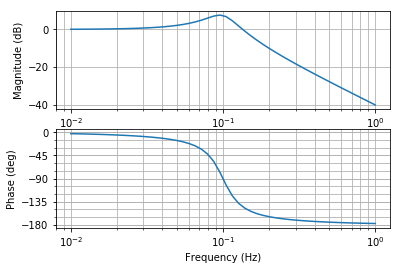

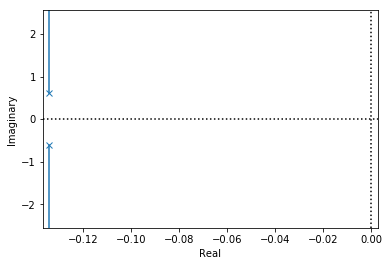

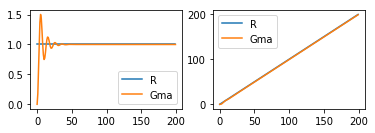

In [0]:
G_MA = tf(Numerador, Denominador)                          # FT em MA, C = 1
print(f"Gma={G_MA}")

e_MA = 1 - dcgain(G_MA)                                   # Erro da planta em MA
print(f"e(∞) = {e_MA}")

# Salva e exibe os polos e zeros da planta
polos_MA = pole(G_MA)
zeros_MA = zero(G_MA)
print(f"Polos de G(s) -> {polos_MA}")
print(f"Zeros de G(s) -> {zeros_MA}")

# Salva os dados de resposta em frequencia
[mag,phase,wout] = bode(G_MA);

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MA = stepinfo(G_MA)
print(f"stepinfo: ")
for info in infoG_MA:
  print(f"\t{info}: {infoG_MA[info]}")

# resposta perante a entrada e root locus da planta
y_step = lsim(G_MA, step, t)
y_ramp = lsim(G_MA, ramp, t)
rlocusG_MA = rlocus(G_MA)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gma"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gma"])
plt.show()

## 2. Determinar parametros do compensador

In [0]:
# Determinando o coeficiente de amortecimento, psi = ξ
psi     = np.arange(0, 1, 0.01)
MpVetor = 100*np.exp(((-1*psi*np.pi)/np.sqrt(1-psi**2)))
MpLoc   = np.where(MpVetor>=(Mp_esp-Mp_folga))[-1][-1] + 1
psi     = round(psi[MpLoc], 4)

print(f"ξ  = {psi}")

# Determinando a frequencia natural, Wn
Wn_s    = symbols('Wn_s')
eq_Wn   = [4/(psi*Wn_s)-ts_esp]
Wn      = solve(eq_Wn, Wn_s)
Wn      = round(Wn[Wn_s], 4)

print(f"Wn = {Wn}\t rad/s")

# Parametros de uma função de 2ª ordem
sigma   = psi * Wn
Wd      = Wn * np.sqrt(1-psi**2)

print(f"σ  = {sigma}")
print(f"Wd = {Wd}")

ξ  = 0.83
Wn = 0.241	 rad/s
σ  = 0.20002999999999999
Wd = 0.13442097715758503


## 3. Projetando o compensador PID

In [0]:
# parametros do compensador
Kc = 2* psi * p / (Kp_MA * Wn)
Ti = Kc * Kp_MA / p
Td = p / Kc

print(f"Kc = {Kc}")
print(f"Ti = {Ti}")
print(f"Td = {Td}")

# Compensador PI
C = tf(np.array([Kc*Ti*Td,Kc*Ti,Kc], dtype=float), np.array([Ti,0], dtype=float))

print(f"C = {C}")

Kc = 68.87966804979253
Ti = 6.887966804979253
Td = 0.14518072289156628
C = 
68.88 s^2 + 474.4 s + 68.88
---------------------------
          6.888 s



## 4. Verifica o comportamento do sistema com o compensador

Malha Aberta
C(s) * G(s) = 
  27.19 s^2 + 187.3 s + 27.19
-------------------------------
6.888 s^3 + 1.847 s^2 + 2.719 s

*********************************************
Malha Fechada
Gmf = 
     27.19 s^2 + 187.3 s + 27.19
-------------------------------------
6.888 s^3 + 29.04 s^2 + 190 s + 27.19

*********************************************
stepinfo: 
	RiseTime: 0.19163308434479231
	SettlingTime: 1.5330646747583385
	SettlingMin: 0.8931761147527267
	SettlingMax: 1.3468851567174989
	Overshoot: 34.69026822854752
	Undershoot: 0.0
	Peak: 1.3468851567174989
	PeakTime: 0.4790827108619808
	SteadyStateValue: 0.9999869882448028
Rlocus de C(s) * G(s):


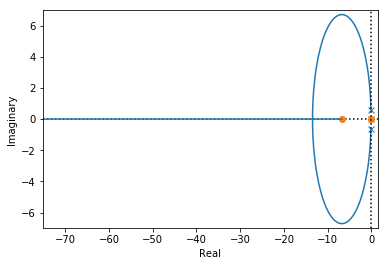

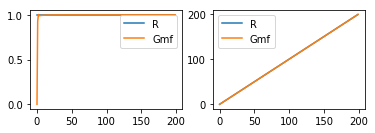

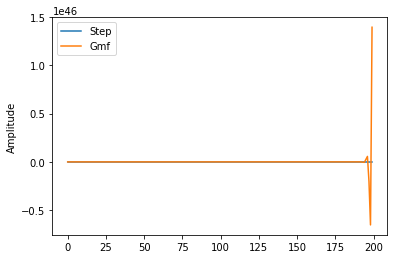

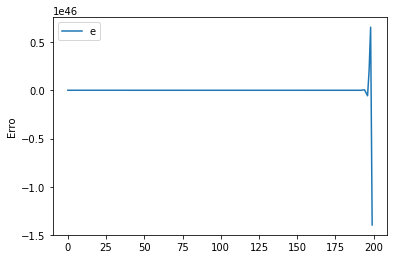

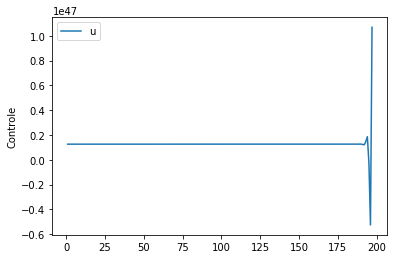

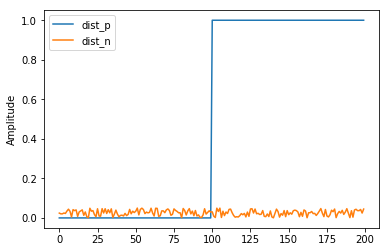

*********************************************
e(∞) = 0.09999999999999432
*********************************************
Rlocus de gmf


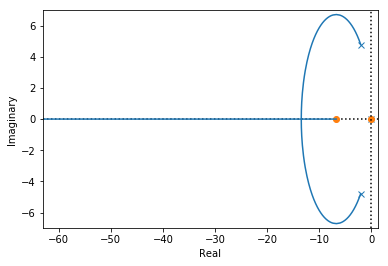

In [0]:
print("Malha Aberta")
CG_MA       = C * G_MA
print(f"C(s) * G(s) = {CG_MA}")

print("*********************************************")
print("Malha Fechada")
G_MF        = feedback(CG_MA, 1)
print(f"Gmf = {G_MF}")

print("*********************************************")

# Verifica as informações do sistema perante a uma entrada degrau
infoG_MF     = stepinfo(G_MF)
print(f"stepinfo: ")
for info in infoG_MF:
  print(f"\t{info}: {infoG_MF[info]}")

# Verifica a resposta em frequencia
# bode(G_MA)
# bode(CG_MA)
print("Rlocus de C(s) * G(s):")
rlocusCG_MA = rlocus(CG_MA)
# resposta perante a entrada e root locus da planta
y_step = lsim(G_MF, step, t)
y_ramp = lsim(G_MF, ramp, t)
plt.figure()                                                # create a plot figure
plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.plot(t, step)
plt.plot(t, y_step[0])
plt.legend(["R", "Gmf"])
plt.subplot(2, 2, 2)
plt.plot(t, ramp)
plt.plot(t, y_ramp[0])
plt.legend(["R", "Gmf"])
plt.show()

# monta o sistema em MF com perturbações
Gmf         = feedback(CG_MA, 1);
Gd1         = feedback(G_MA, CG_MA);         # perturbação entre o controlador e a planta
Gd2         = feedback(1, CG_MA);           # pertubação na saida da planta

# verifica a resposta do sistema frente a um step
yma_step    = lsim(G_MA, step, t);
ymf_step    = lsim(G_MF, step, t);
yd1_step    = lsim(Gd1, dist_p, t);
yd2_step    = lsim(Gd2, dist_n, t);
y_step      = ymf_step[0]+yd1_step[0]+yd2_step[0]

# ----- calculo do erro
yr = step;
er = yr-y_step;
u   = er[1:-2]*Kc+sum(er[1:-2])*(Kc/Ti)+(er[1:-2]-er[2:-1])*(Kc*Td);
plt.plot(t, step)
plt.plot(t, y_step)
plt.legend(["Step", "Gmf"])
plt.ylabel("Amplitude")
plt.show()
plt.plot(t, er)
plt.legend("e")
plt.ylabel("Erro")
plt.show()
plt.plot(t[1:-2], u)
plt.legend("u")
plt.ylabel("Controle")
plt.show()
plt.plot(t, dist_p)
plt.plot(t, dist_n)
plt.legend(["dist_p", "dist_n"])
plt.ylabel("Amplitude")
plt.show()
print("*********************************************")
e_MF         = ramp[-1] - y_ramp[0][-1]     #erro apos ser adicionado o controlador ao
print(f"e(∞) = {e_MF}")
print("*********************************************")
print("Rlocus de gmf")
rlocusG_MF = rlocus(G_MF)